In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree

In [5]:
# Laddar upp datasetet. sep är för att tala om att det är delat med ;
dataSet = pd.read_csv('DataCSV.csv', sep=';', header =1)

In [6]:
# Tar bort alla deciamlkomma som störde ut hela filen
colsToDrop = [col for col in dataSet.columns if 'Unnamed' in col]
dataSet = dataSet.drop(columns=colsToDrop)

In [7]:
# Skriver ut allt å ser så det är bra.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print (dataSet)

      SFH  popUpWidnow  SSLfinal_State  Request_URL  URL_of_Anchor  \
0       1           -1               1           -1             -1   
1      -1           -1              -1           -1             -1   
2       1           -1               0            0             -1   
3       1            0               1           -1             -1   
4      -1           -1               1           -1              0   
5      -1           -1               1           -1             -1   
6       1           -1               0            1             -1   
7       1            0               1            1              0   
8      -1           -1               0           -1             -1   
9      -1            0              -1           -1              1   
10     -1           -1               0           -1             -1   
11      1            0               1            1              1   
12      1           -1               0           -1              1   
13      1           

In [8]:
# Dela upp datan i target(y) och alla futeres(x) som den ska tränas på. 

# *** Orginaldata
targetColumn = 'Resultat'
y = dataSet[targetColumn]
x = dataSet.drop(targetColumn, axis=1)




In [9]:
# Skriver ut de olka dataseten
print("Orginaldata:                      dataSet")


print("Target data Orginal:              y")
print("FuturesData Orginal:              x")
print()


Orginaldata:                      dataSet
Target data Orginal:              y
FuturesData Orginal:              x



In [30]:
# Vi skapar listor för att spara resultaten av de 100  första körningarna. accuracy, precision, recall, och f1 score
# Orginal med 90/10
resultTestOne = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1Score": []
    }

# Behöver skapa en tom matris som vi kan lägga in resultaten i för confusion matrix.
# Antal klasser (-1, 0, 1) 
numClasses = 3 

# Matris som summerar 100 iterationer
summorizedMatrix = np.zeros((numClasses, numClasses), dtype=int)

In [33]:
# Nu ska vi köra första loopen med orginladatan och 90/10 fördelning.

# Först loopen
for i in range(100):
    # Delning träning/testdata
    xTrain, xTest, yTrain, yTest  = train_test_split(x, y, test_size= 0.1, random_state=None)
    
    # Vi Tränar modellen
    model = DecisionTreeClassifier(random_state=123)
    model.fit(xTrain, yTrain)

    # Vi prediktar värden på testdatan
    predictions = model.predict(xTest)

    # För att köra confusion matrix behövs konvertering till index 0,1,2
    yTestIndexed = yTest + 1
    predictionsIndexed = predictions + 1

    # Beräkna matrix för denna loop
    matrixCurrent = confusion_matrix(yTestIndexed, predictionsIndexed, labels=range(numClasses))

    # Summera Matrix
    summorizedMatrix += matrixCurrent

    # Skapar rapporten och plockar ut datan. "out_put=True" = Returnerar rapporten som en dictionary istället för
    # att skriva ut den direkt. 
    report = classification_report(yTest, predictions, output_dict=True)

    # Sparar resultatetn från varje varv.
    resultTestOne["accuracy"].append(report['accuracy'])
    resultTestOne["precision"].append(report['weighted avg']['precision'])
    resultTestOne["recall"].append(report['weighted avg']['recall'])
    resultTestOne["f1Score"].append(report['weighted avg']['f1-score'])
    
#Skriver ut att loopen är klar
print("100 körningar gjorda.")

100 körningar gjorda.


In [28]:
# Då ska vi beräkna medelvärdena för resultaten
meanAccuracy = np.mean(resultTestOne["accuracy"])
meanPrecision = np.mean(resultTestOne["precision"])
meanRecall = np.mean(resultTestOne["recall"])
meanF1 = np.mean(resultTestOne["f1Score"])

# Skriv ut och presentera
print("Medelvärden för Orginaldata med 90/10 fördelning")
print()
print(f"Medel Accuracy: {meanAccuracy:.2f}")
print(f"Medel Precision: {meanPrecision:.2f}")
print(f"Medel Recall: {meanRecall:.2f}")
print(f"Medel F1-Score: {meanF1:.2f}")

Medelvärden för Orginaldata med 90/10 fördelning

Medel Accuracy: 0.88
Medel Precision: 0.89
Medel Recall: 0.88
Medel F1-Score: 0.88


In [36]:
print("Skriver ut en summerad confusion matrix")
print()
print(summorizedMatrix)

Skriver ut en summerad confusion matrix

[[6397  116  575]
 [ 100  890   61]
 [ 673  133 4655]]


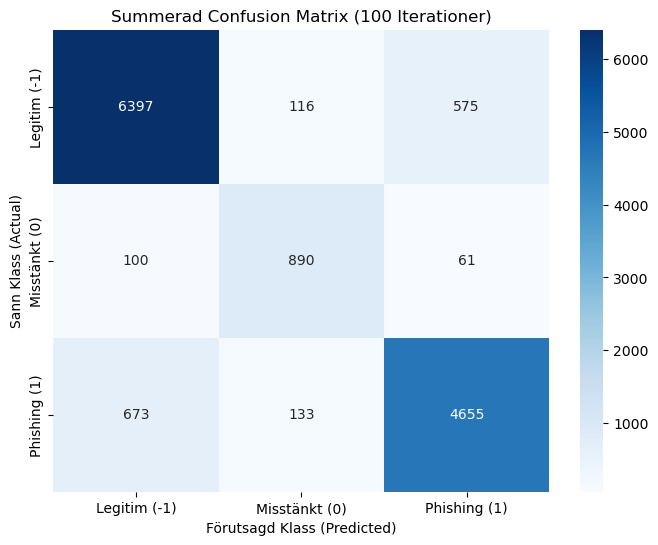

In [44]:
# Presentera cm lite snyggare.

# Klassnamnen
classNames = ['Legitim (-1)', 'Misstänkt (0)', 'Phishing (1)' ]

# Gör figuren och axlarna
plt.figure(figsize=(8, 6))

# Gör en heatmap
sns.heatmap(summorizedMatrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=classNames, yticklabels=classNames)

# Lägger till etiketter och titel
plt.title('Summerad Confusion Matrix (100 Iterationer)')
plt.ylabel('Sann Klass (Actual)')
plt.xlabel('Förutsagd Klass (Predicted)')

plt.show()